> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#omar">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [22]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [23]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df=pd.read_csv('noshowappointments-kagglev2-(may)-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [24]:
df.shape

(110527, 14)

In [25]:
sum(df.duplicated())

0

In [26]:
sum(df.duplicated(['PatientId','No-show']))

38710

In [27]:
#has 38710 PatientId have same status of showing or not!

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [29]:
# no missing valuse 

In [30]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [31]:
#mean age =37 , max age=115 , min age =-1 make a mistake will remove that

In [32]:
mistake=df.query('Age=="-1"')
mistake

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [35]:
df.drop(index=99832, inplace=True)

In [42]:
##REMOVE THE -1 VALUE OF AGE



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [ ]:
#remove unnesscasry data 
df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'] ,axis=1 , inplace =True)

In [45]:
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (Replace this header name!)

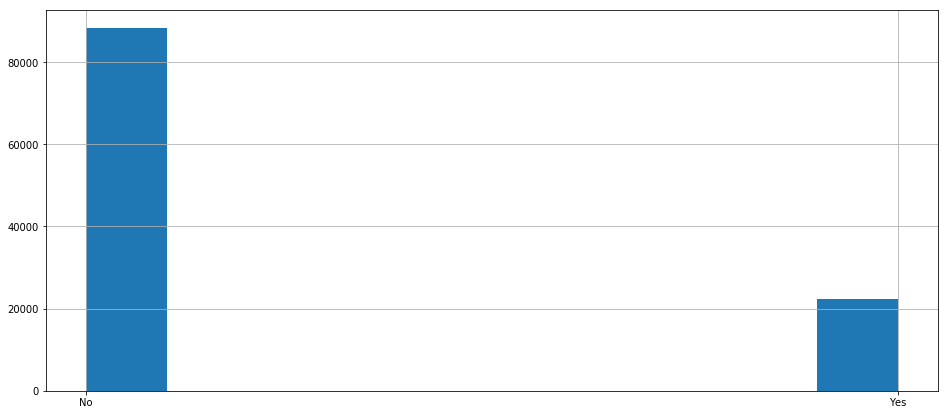

In [85]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
df['No-show'].hist(figsize=(16,7));

In [116]:
#divided the data into 2 groups to "No-show"
noshow=df['No-show']=='Yes'
show=df['No-show']=='No'
df[show].count(),"    &       ",df[noshow].count()

(Gender           88207
 Age              88207
 Neighbourhood    88207
 Scholarship      88207
 Hipertension     88207
 Diabetes         88207
 Alcoholism       88207
 Handcap          88207
 SMS_received     88207
 No-show          88207
 dtype: int64, '    &       ', Gender           22319
 Age              22319
 Neighbourhood    22319
 Scholarship      22319
 Hipertension     22319
 Diabetes         22319
 Alcoholism       22319
 Handcap          22319
 SMS_received     22319
 No-show          22319
 dtype: int64)

In [114]:
# number of showed is 88207 about 4 times grater than not showed

In [118]:
df[show].mean(),df[noshow].mean()

(Age             37.790504
 Scholarship      0.093904
 Hipertension     0.204394
 Diabetes         0.073838
 Alcoholism       0.030417
 Handcap          0.022742
 SMS_received     0.291337
 dtype: float64, Age             34.317667
 Scholarship      0.115507
 Hipertension     0.169004
 Diabetes         0.064071
 Alcoholism       0.030333
 Handcap          0.020297
 SMS_received     0.438371
 dtype: float64)

In [ ]:
# mean age show is 38 , mean age noshow is 34,,,showed patient received sms is less than no showed patient received sms

In [ ]:
# What factors are
# important for us to
# know in order to
# predict if a patient will
# show up for their
# scheduled
# appointment?df.Age[show].hist(alpha=0.5,lable="show" );
df.Age[noshow].hist(alpha=0.5,bin=10,color='red',lable="noshow" );


In [161]:
# FIRST q1 dose age has effect on attendence

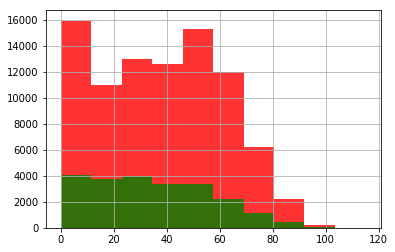

In [223]:
df.Age[show].hist(alpha=0.8 ,color="red");
df.Age[noshow].hist(alpha=0.8 ,color="green");


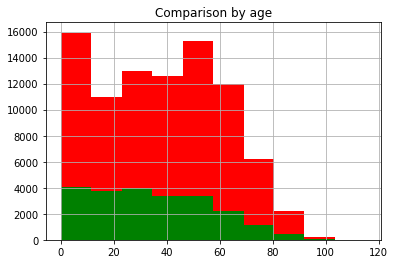

In [222]:
def attendence(df,col_name,attendence,absent):
    df[col_name][show].hist(color="red")
    df[col_name][noshow].hist(color="green")
    plt.legend();
    plt.title('Comparison by age');
    
attendence(df,'Age',show,noshow)

In [164]:
# from(0 : 10) are the most showing then (45 : 58) the less attendece is from (65:100)

In [168]:
###  Question 2  ( dose Hipertension ,Diabetes has effect!)

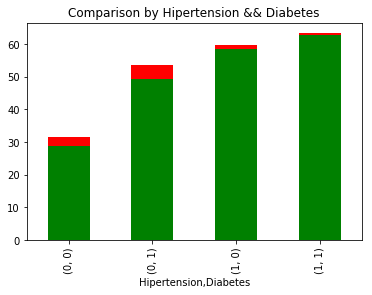

In [213]:
df[show].groupby(['Hipertension', 'Diabetes']).mean()['Age'].plot(kind='bar',color='red')
df[noshow].groupby(['Hipertension', 'Diabetes']).mean()['Age'].plot(kind='bar',color='green')
plt.title('Comparison by Hipertension && Diabetes');

In [199]:
df[show].groupby(['Hipertension','Diabetes']).mean()

Age  Scholarship  Alcoholism   Handcap  \
Hipertension Diabetes                                                 
0            0         31.510433     0.096609    0.022272  0.015983   
             1         53.666952     0.089041    0.053938  0.032534   
1            0         59.702144     0.092242    0.068827  0.041627   
             1         63.406361     0.063985    0.039289  0.063050   

                       SMS_received  
Hipertension Diabetes                
0            0             0.290683  
             1             0.267979  
1            0             0.301640  
             1             0.280449

In [198]:
df[noshow].groupby(['Hipertension','Diabetes']).mean()

Age  Scholarship  Alcoholism   Handcap  \
Hipertension Diabetes                                                 
0            0         28.834155     0.118907    0.023004  0.014240   
             1         49.183391     0.121107    0.044983  0.013841   
1            0         58.377043     0.107944    0.075257  0.047891   
             1         62.820333     0.077125    0.040316  0.055215   

                       SMS_received  
Hipertension Diabetes                
0            0             0.445120  
             1             0.387543  
1            0             0.423033  
             1             0.378615

In [200]:
# Hipertension,Diabetes almost not effect on show or not show

In [201]:
### q3 dose gender effect

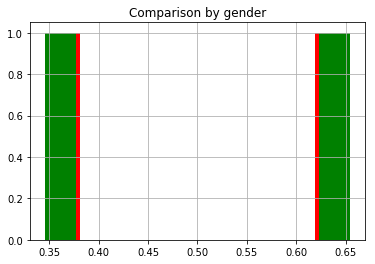

In [221]:
def attendence(df,col_name,attendence,absent):
    df[col_name][show].value_counts(normalize=True).hist(color="red")
    df[col_name][noshow].value_counts(normalize=True).hist(color="green")
    plt.legend();
    plt.title('Comparison by gender');
    
attendence(df,'Gender',show,noshow)

In [211]:
#gender has no effect

In [ ]:
#dose age && Gender has effect on show

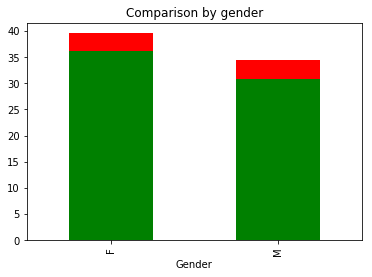

In [216]:
df[show].groupby('Gender').mean()['Age'].plot(kind='bar',color='red')
df[noshow].groupby('Gender').mean()['Age'].plot(kind='bar',color='green')
plt.title('Comparison by gender');

# age && Gender has no effect on show


# q4 receved sms

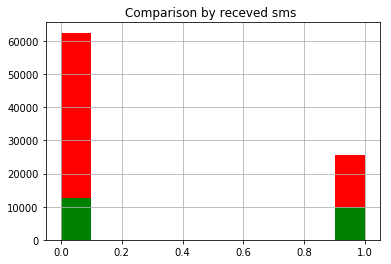

In [220]:
def attendence(df,col_name,attendence,absent):
    df[col_name][show].hist(color="red")
    df[col_name][noshow].hist(color="green")
    plt.legend();
    plt.title('Comparison by receved sms ');
    
attendence(df,'SMS_received',show,noshow)

# must take care about sms


# q5 Neighbourhood

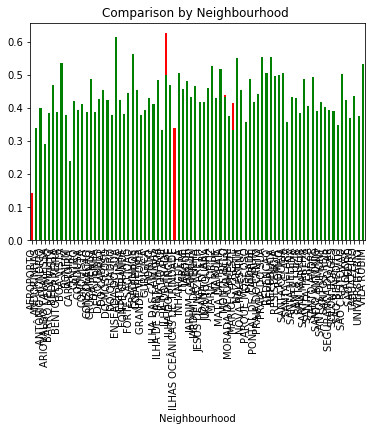

In [219]:
df[show].groupby('Neighbourhood').SMS_received.mean().plot(kind='bar',color='red')
df[noshow].groupby('Neighbourhood').SMS_received.mean().plot(kind='bar',color='green')
plt.title('Comparison by Neighbourhood ');

# Neighbourhood has effect on show

<a id='conclusions'></a>
## Conclusions

> **Tip**: Neighbourhood has great effect on showing
Age has effect (0:10) and (45:58) the most attendece and the low attendence is from(65:100)
showed patient received sms is less than no showed patient received sms


> **Tip**: If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

### Limitations
> **Tip**: no effect on show with gender and Hipertension && Diabetes .


In [160]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0